#This Project is developed to take a wav file of a single voice of music and get the musical pitch at any time frame.

Testing with ShortTimeFFT SciPy


Imports:

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import statistics
import random
import math
import librosa
import json
import os
import glob

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann

Name of User (used in application)

In [93]:
userId = 'user'

ONLY SET TO TRUE DURING TESTING: graphs every segment of audio (largely increases run time)

In [94]:
fullgraph = False

if fullgraph == True:
    files = glob.glob('./data/processed/plotPartial/*.png')
    for f in files:
        os.remove(f)

Load audio file (only accepts .wav file)

In [95]:
fileName = "sample7.wav"
originalFileLoc = "./data/raw/" + fileName
x, sr = librosa.load(originalFileLoc)
audioDuration = librosa.get_duration(y=x, sr=sr)

Set values

In [96]:
#What decimal to round time / signal too
defaultDecimalRate = 5
#Rate to lower bit by
defaultLoweringRate = 3
#How long each frequency reading should be (in seconds)
defaultDurationTime = 0.1

defaultMinDist = defaultDurationTime

pitchToLetter = {
    0: 'C',
    1: 'C#',
    2: 'D',
    3: 'D#',
    4: 'E',
    5: 'F',
    6: 'F#',
    7: 'G',
    8: 'G#',
    9: 'A',
    10: 'A#',
    11: 'B'
}

pitches = {0: 65.406}
currentPitch = 0
while currentPitch <= 71:
    prevPitch = pitches[currentPitch]
    currentPitch += 1            
    pitches[currentPitch] = prevPitch * (2 ** (1/12))

(optional) show audio file for comparison (musicSample.png for demo)

In [97]:
# music file = musicSample.png
timeListSample = [0, 2, 2, 4, 4, 6, 6, 8, 8, 10, 10, 12, 12, 14, 14, 16]
pitchListSample = [14, 14, 16, 16, 18, 18, 19, 19, 21, 21, 23, 23, 25, 25, 26, 26]

for i in range(len(pitchListSample)):
    pitchListSample[i] += 24

gradingDictSample = {}
for i in range(len(timeListSample) // 2):
    gradingDictSample[timeListSample[i * 2]] = {
        "startTime": timeListSample[i * 2],
        "pitchClass": pitchListSample[i * 2],
        "endTime": timeListSample[(i * 2) + 1]
    }


Get notes from freq

In [98]:
def freqToNotes(freqList):
    retFreqList = []
    for x in freqList:
        if (x >= 65.406):
            retFreqList.append((12 * math.log((500 * x) / 32523)) / (math.log(2)))
        else: 
            retFreqList.append(-1)
    return retFreqList

Create Functions

In [99]:
def is_close(a, b, tolerance=1e-2):
       return abs(a - b) < tolerance

def lowerRate(lst, rte, decimalRate):
    """(List of signal, updated rate (x))
    Used to lower bitrate by a factor of x to fix fuzz"""
    retList = []
    for i in range(int(len(lst) / rte) - 1):
        includedIndices = [lst[i * rte]]
        for j in range(rte):
            includedIndices.append(lst[(i * rte) + j + 1])
        retList.append(round(statistics.median(includedIndices),decimalRate))
    return (retList)

Pitch Analyzer Class:

In [100]:

class PitchAnalyzer:
    def __init__(self, filename, decimalRate = defaultDecimalRate, loweringRate = defaultLoweringRate, minDist = defaultMinDist, durationTime = defaultDurationTime):
        self.decimalRate = decimalRate
        self.loweringRate = loweringRate
        self.minDist = minDist
        self.durationTime = durationTime
        self.freqDict = {}
        
        
        y, sr = librosa.load(filename, sr=None)

        # Estimate pitch with PYIN
        f0, voiced_flag, voiced_probs = librosa.pyin(
            y,
            fmin=librosa.note_to_hz('C2'),
            fmax=librosa.note_to_hz('C7'),
            sr=sr
        )
        
        f0 = np.where(np.isnan(f0), np.nan, f0 * 4.1)
                
        times = librosa.times_like(f0, sr=sr)  # time (s) for each frame

        # --- Calculate median pitch per 2s window ---
        window_length = 2.0  # seconds
        total_length = times[-1]
        median_pitches = []
        median_times = []

        cur_start = 0.0
        while cur_start < total_length:
            cur_end = cur_start + window_length
            # indices in this time window
            idxs = np.where((times >= cur_start) & (times < cur_end))[0]
            window_f0 = f0[idxs]
            # Only take non-NaN (voiced)
            valid_pitches = window_f0[~np.isnan(window_f0)]
            if len(valid_pitches) > 0:
                this_median = np.median(valid_pitches)
            else:
                this_median = np.nan  # Or 0, or skip as you prefer
            # Use center of window for plotting/matching
            median_times.append(cur_start + window_length/2)
            median_pitches.append(this_median)
            cur_start += window_length

        # --- PLOT ---

        plt.figure(figsize=(12, 7))

        # 1. Continuous pitch
        plt.subplot(2, 1, 1)
        plt.plot(times, f0, color='purple')
        plt.title('PYIN Estimated Pitch (All Frames)')
        plt.xlabel('Time (s)')
        plt.ylabel('Pitch (Hz)')

        # 2. Median in 2s windows
        plt.subplot(2, 1, 2)
        plt.plot(median_times, median_pitches, 'o-', color='green', label='Window Median')
        plt.title('Median Pitch (each 2s window)')
        plt.xlabel('Window Center Time (s)')
        plt.ylabel('Median Pitch (Hz)')
        plt.tight_layout()
        plt.show()

        # Your lists:
        print('Median pitches:', median_pitches)
        print('Window center times:', median_times)
        
        retFreqList = freqToNotes(median_pitches)

        timeFreqDict = {}
        for i in range(len(median_times)):
            currentPitchClass = retFreqList[i]
            currentNoteName = round(currentPitchClass, 0)
            currentNoteCents = currentPitchClass - currentNoteName
            currentNoteName %= 12
            currentNoteName = pitchToLetter[currentNoteName]
            retDict = {
                "pitchClass" : round(currentPitchClass, 0),
                "noteName" : currentNoteName,
                "cents_innacurate" : currentNoteCents,
            }
            timeFreqDict[round(median_times[i], defaultDecimalRate)] = retDict
            
        self.freqDict = timeFreqDict
        
        with open("./data/processed/timeFreq.json", "w") as outfile:
            json.dump(timeFreqDict, outfile)


        plt.figure(1)
        plt.title("Pitch class error over time (seconds)" )
        plt.axhline(y=0, color='blue', linestyle='--')
        plt.plot(timeListSample[::2], self.gradeSelf(gradingDictSample), color = 'red', label = "Inaccuracy")
        plt.show()
        # plt.savefig("./data/processed/Error" + userId + ".png")
        plt.close()    
        
        return
                        
                        
    def gradeSelf(self, gradingDict):
        
        #Grade by (weighed median towards lower grade / classic median)
        
        noteGradeList = []
        for i in gradingDict:
            currentGradedDict = gradingDict[i]
            
            userPitchList = []
            currentTime = currentGradedDict["startTime"]
            while currentTime <= currentGradedDict["endTime"]:
                currentTime = round(currentTime, defaultDecimalRate)
                if currentTime in self.freqDict:
                    userPitchList.append(self.freqDict[currentTime]['pitchClass'] + self.freqDict[currentTime]['cents_innacurate'])
                currentTime += defaultDurationTime
            
            pitchDifferenceList = []
            for j in userPitchList:
                pitchDifferenceList.append(min([((j%12) - (currentGradedDict["pitchClass"]%12))], key=abs))
            medianSquareError = statistics.median(pitchDifferenceList)
            noteGradeList.append(medianSquareError)
            
        
            
            
        return(noteGradeList)
            
    def createFinalGrade(self, gradingDict):
        noteGradeList = self.gradeSelf(gradingDict)
        retGrade = 100.0
        totalNotes = len(noteGradeList)
        for i in noteGradeList:
            thisGrade = abs(i) ** 2
            if thisGrade >= 1:
                thisGrade = 1
            retGrade -= thisGrade * (100/totalNotes)
        return(retGrade)
    

Create analyzer

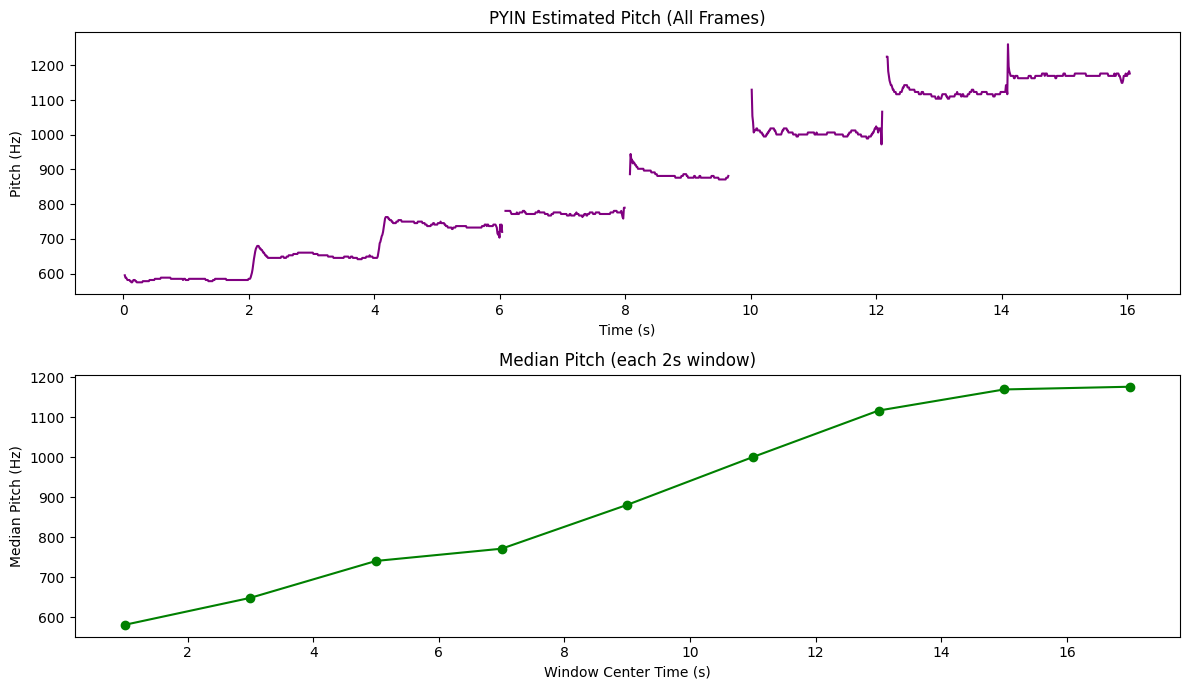

Median pitches: [np.float64(581.5060091062502), np.float64(648.9590445848797), np.float64(741.1646637563828), np.float64(771.746713165707), np.float64(881.3982915276896), np.float64(1000.8316638051961), np.float64(1116.925277060451), np.float64(1169.7492782952106), np.float64(1176.5255669285386)]
Window center times: [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0]


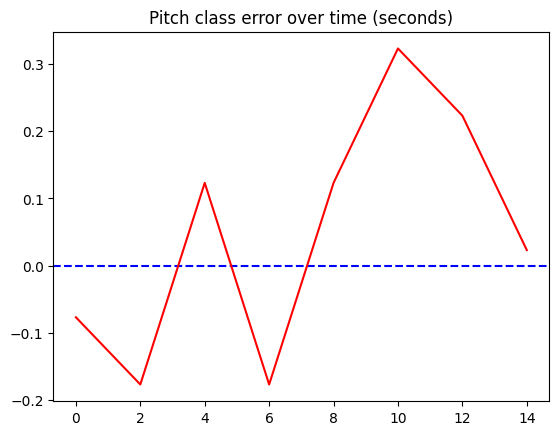

In [101]:
thisAnalyzer = PitchAnalyzer(originalFileLoc)

In [102]:
print(thisAnalyzer.gradeSelf(gradingDictSample))
print(thisAnalyzer.createFinalGrade(gradingDictSample))

[-0.07685775425862573, -0.17685775425862715, 0.12314224574137, -0.17685775425863426, 0.12314224574137, 0.32314224574136574, 0.22314224574136432, 0.023142245741368583]
96.83073241749784
